# Analysis of the jena climate dataset: inspection of the temperature series

In [8]:
# code adapted from F. Chollet, Deep learning with python, 2018

#### Import of the necessary packages:

In [3]:

import os
from pip._vendor.urllib3 import add_stderr_logger

import numpy as np
from matplotlib import pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras import regularizers
from keras import layers
from keras.optimizers import RMSprop
from keras.optimizers import Adam

Using TensorFlow backend.


#### Inspection of data of the Jena weather dataset:


data_dir ='/Users/Andreas/Documents/GitHub/PredRecNets/jena_climate'
fname  = os.path.join(data_dir,'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))


#### Reading the data  and saving as a numpy array:

In [5]:

float_data = np.zeros((len(lines),len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values
    
print(float_data[0,:])

[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


#### Plot of the entire temperature timeseries:

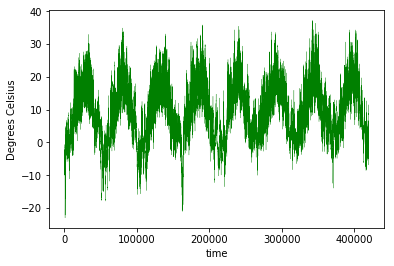

In [6]:

temp = float_data[:,1]
plt.plot(range(len(temp)),temp,color="green", linewidth=0.25, linestyle="-")
plt.xlabel('time')
plt.ylabel('Degrees Celsius')
plt.show()


#### Plot of the first 20 days of the temperature series:

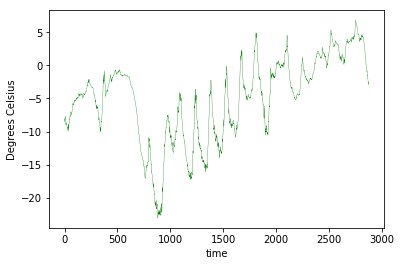

In [10]:

plt.plot(range(2*1440),temp[:2*1440],color="green", linewidth=0.3, linestyle="-")
plt.xlabel('time')
plt.ylabel('Degrees Celsius')
plt.show()


#### Normalization of the data:
One normalizes all timeseries of the entire dataset so that they take values on a similar scale.

In [48]:

mean = float_data[:200000].mean(axis=0)
float_data -=mean
std = float_data[:200000].std(axis=0)
float_data /= std


#### Data generator:
This generator produces tuples of temperature samples and targets.

In [12]:

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else: 
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data [indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


#### Preparation of the training, validation and test generators:
Explanations of the parameters:
Lookback: We will go back # of timesteps as a basis of observation.
steps: We sample at 2 points per hour.
delay: The target data looks 24 hours into the future.


In [14]:

lookback = 720
step = 3
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback = lookback, 
                      delay = delay, 
                      min_index = 0, 
                      max_index = 200000, 
                      shuffle = True, 
                      step = step, 
                      batch_size = batch_size)

val_gen = generator(float_data, 
                      lookback = lookback, 
                      delay = delay, 
                      min_index = 200001, 
                      max_index = 300000,  
                      step = step, 
                      batch_size = batch_size)

test_gen = generator(float_data, 
                      lookback = lookback, 
                      delay = delay, 
                      min_index = 300001, 
                      max_index = None,  
                      step = step, 
                      batch_size = batch_size)

val_steps = (300000-200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128


#### Training and evaluation using a densely connected model
We first use a simple dense model before employing more complicated RNNs.
Flattening is employed which is typical for such networks. One may say that
this removes the sequence aspect of the data and is to be contrasted to 
canonical sequence models (GRU, LSTM) where flattening is absent to respect
the ordering of the data in time.

In [16]:

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
#keras.layers.Dropout(0.1, noise_shape=None, seed=None)
model.add(keras.layers.Dense(32, activation = 'relu'))
#model.add(keras.layers.Dense(8, activation = 'relu'))
model.add(keras.layers.Dense(1)) # no activation function is chosen since this is a regression problem

model.summary()

model.compile(optimizer = keras.optimizers.Adam(lr=0.005), loss = 'mae') # the error metric is MAE : mean absulute error
historyFCC= model.fit_generator(train_gen,
                              steps_per_epoch = 500, # original value is 500
                              epochs = 20, # original value is 20
                              validation_data = val_gen,
                              validation_steps = val_steps)

#print(model.get_weights())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 18s 35ms/step - loss: 1.5548 - val_loss: 0.9043
Epoch 2/20
500/500 [==============================] - 17s 34ms/step - loss: 0.5929 - val_loss: 0.4388
Epoch 3/20
500/500 [==============================] - 17s 33ms/step - loss: 0.3959 - val_loss: 0.5033
Epoch 4/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2946 - val_loss:

#### Training and evaluation of a simple recurrent NN:

We set up a recurrent NN a la GRU first. Observe that there is no "keras.layers.Flatten(input_shape..." present. The input_shape argument follows in the GRU layer. The Flatten-method would remove the sequential aspect (causality and order) of the data but this is exactly what we want to analyze using the recurrent model.

In [17]:

model = keras.models.Sequential()
model.add(keras.layers.GRU(32,activation='relu',kernel_regularizer=regularizers.l2(0.001), input_shape = (None, float_data.shape[-1])))
model.add(keras.layers.Dense(1))

model.summary()

model.compile(optimizer = keras.optimizers.Adam(lr=0.005,clipnorm=1.0), loss = 'mae')
historyGRU = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

#print(model.get_weights())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 191s 382ms/step - loss: 0.2995 - val_loss: 0.2715
Epoch 2/20
500/500 [==============================] - 192s 385ms/step - loss: 0.2880 - val_loss: 0.2750
Epoch 3/20
500/500 [==============================] - 202s 405ms/step - loss: 0.2814 - val_loss: 0.2785
Epoch 4/20
500/500 [==============================] - 206s 412ms/step - loss: 0.2728 - val_loss: 0.2875
Epoch 5/20
500/500 [==============================] - 209s 418ms/step - loss: 0.2674 - val_loss: 0.2672
Epoch 6/20
500/5

#### Training an evaluation of a bidirectional recurrent NN:
We set up bidirectional GRU with one layer. For a problem such as temperature prediction, information coming
from the reversed direction cannot have a major impact as the
temperature is effected by the recent past as we know. So we do not
expect much gains from such an architecture here. The bidirectionality is introduced via "model.add(keras.layers.Bidirectional(keras.layers.GRU(32),..." where the first GRU is argument to the Bidirectional section.

In [18]:

model = keras.models.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.GRU(32),
                           input_shape = (None, float_data.shape[-1])))
model.add(keras.layers.Dense(1))

model.summary()

model.compile(optimizer = keras.optimizers.Adam(lr=0.005), loss = 'mae')
historyGRUbi = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

#print(model.get_weights())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 64)                9024      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 229s 458ms/step - loss: 0.2869 - val_loss: 0.2705
Epoch 2/20
500/500 [==============================] - 224s 448ms/step - loss: 0.2599 - val_loss: 0.2724
Epoch 3/20
500/500 [==============================] - 217s 435ms/step - loss: 0.2393 - val_loss: 0.2956
Epoch 4/20
500/500 [==============================] - 220s 439ms/step - loss: 0.2188 - val_loss: 0.3038
Epoch 5/20
500/500 [==============================] - 220s 439ms/step - loss: 0.2054 - val_loss: 0.3090
Epoch 6/20
500/5

#### Training and evaluation of a recurrent NN with dropout:

We set up a recurrent NN a la GRU with dropout to counter the overfitting problem. Notice that dropout regularization for recurrent models applies the dropout mask at every timestep in the same way. This is to be contrasted to the procedure for densely connected models (dropout at random). To this aim, we need to include "dropout" and "recurrent_dropout" in the GRU layer argument. (Actually, we would need more epochs due to dropout to get a converging model. We abstain from this here.)

In [19]:

model = keras.models.Sequential()
model.add(keras.layers.GRU(32,
                           dropout = 0.2,
                           recurrent_dropout = 0.2,kernel_regularizer=regularizers.l2(0.001),activation='relu',
                           input_shape = (None, float_data.shape[-1])))
model.add(keras.layers.Dense(1))

model.summary()

model.compile(optimizer = keras.optimizers.Adam(lr=0.005,clipnorm=1.), loss = 'mae')
historydropout = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

#print(model.get_weights())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 203s 406ms/step - loss: 0.3292 - val_loss: 0.2817
Epoch 2/20
500/500 [==============================] - 202s 405ms/step - loss: 0.3127 - val_loss: 0.2786
Epoch 3/20
500/500 [==============================] - 201s 403ms/step - loss: 0.3090 - val_loss: 0.2982
Epoch 4/20
500/500 [==============================] - 204s 408ms/step - loss: 0.3028 - val_loss: 0.2767
Epoch 5/20
500/500 [==============================] - 206s 412ms/step - loss: 0.2971 - val_loss: 0.2753
Epoch 6/20
500/5

#### Training and evaluation of a stacked recurrent NN including dropout:
We set up a stacked recurrent NN a la GRU with dropout and two layers. This should be good a) against overfitting b) reach good scores/overcoming 
a potential performance bottleneck as compared to networks of lower capacity. 

Again, we would have to train on more epochs (to counter the dropout) but abstain from this here.  Overfitting can again become a problem if we inflate the network
architecture (layers and their units) to greedily. Notice that intermediate layers have "return_sequences = True" in the argument for which we refer to the jupyter notebook.

In [20]:

model = keras.models.Sequential()
model.add(keras.layers.GRU(32,
                           dropout = 0.2,
                           recurrent_dropout = 0.2,kernel_regularizer=regularizers.l2(0.001),activation='relu',
                           return_sequences = True,
                           input_shape = (None, float_data.shape[-1])))
model.add(keras.layers.GRU(64,
                           activation = 'relu',
                           dropout = 0.1,
                           recurrent_dropout = 0.1))
model.add(keras.layers.Dense(1))

model.summary()

model.compile(optimizer = keras.optimizers.Adam(lr=0.005,clipnorm=1.), loss = 'mae')
historyGRUstacked = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

#print(model.get_weights())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, None, 32)          4512      
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 23,201
Trainable params: 23,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 486s 972ms/step - loss: 0.3324 - val_loss: 0.3058
Epoch 2/20
500/500 [==============================] - 483s 965ms/step - loss: 0.3094 - val_loss: 0.2869
Epoch 3/20
500/500 [==============================] - 488s 975ms/step - loss: 0.3034 - val_loss: 0.2881
Epoch 4/20
500/500 [==============================] - 476s 952ms/step - loss: 0.2951 - val

#### Training and evaluation using a simple 1d CONVNET model:
CONVNETs are able to extract features from local input patches, allow for representational modularity and are data efficient. In fact, 1d CONVNETs can compete with recurrent NNs on some sequence-processing tasks and are less costy. Indeed, 1d convolutions are able to extract local 1d patches, i.e. subsequences, from the entire sequence and thus are able to recognize local patterns in a sequence. Such a pattern can then be recognized at a different position due to the translation invariance of the convolution operation. However, since input patches are independently processed, CONVNETs are not sensitive towards time-ording beyond a local scale. This is demonstrated using the network below.

In [32]:

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer = Adam(lr=0.005,clipnorm=1.), loss = 'mae')

historyCON = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

#print(model.get_weights())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total para

#### Training and evaluation using a model comprising of a 1d CONVNET in conjunction with a simple recurrent NN:

Last, we try a combination of a simple CONVNET together with a subsequent recurrent NN. The idea is to obtain an operation corresponding to a downsampling of the data to shorter high-level featured subsequences which are then fed into the recurrent NN.

In [33]:

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.2,activation='relu'))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=Adam(lr=0.005,clipnorm=1.), loss='mae')
historyCONGRU = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

# print("Weights of the first layer:\n", model.layers[0].get_weights())
# print("Weights of the second layer:\n", model.layers[1].get_weights())
# print("Weights of the third layer:\n", model.layers[2].get_weights())
# print("Weights of the fourth layer:\n", model.layers[3].get_weights())
# print("Weights of the fifth layer:\n", model.layers[4].get_weights())

# model.save_weights('weights_convnet_GRU_chimaera.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 90s 180ms/step - loss: 0.3237 - val_loss: 0.2876
Epoch 2/20
500/500 [===============

#### Gathering of the results in plots:

In [11]:

# --- Setting up the data to be plotted ---

lossFCC = historyFCC.history['loss']
val_lossFCC = historyFCC.history['val_loss']

lossGRU = historyGRU.history['loss']
val_lossGRU = historyGRU.history['val_loss']

lossGRUbi = historyGRUbi.history['loss']
val_lossGRUbi = historyGRUbi.history['val_loss']

lossGRUdropout = historydropout.history['loss']
val_lossGRUdropout = historydropout.history['val_loss']

lossGRUstacked = historyGRUstacked.history['loss']
val_lossGRUstacked = historyGRUstacked.history['val_loss']

lossCON = historyCON.history['loss']
val_lossCON = historyCON.history['val_loss']

lossCONGRU = historyCONGRU.history['loss']
val_lossCONGRU = historyCONGRU.history['val_loss']


NameError: name 'historyFCC' is not defined

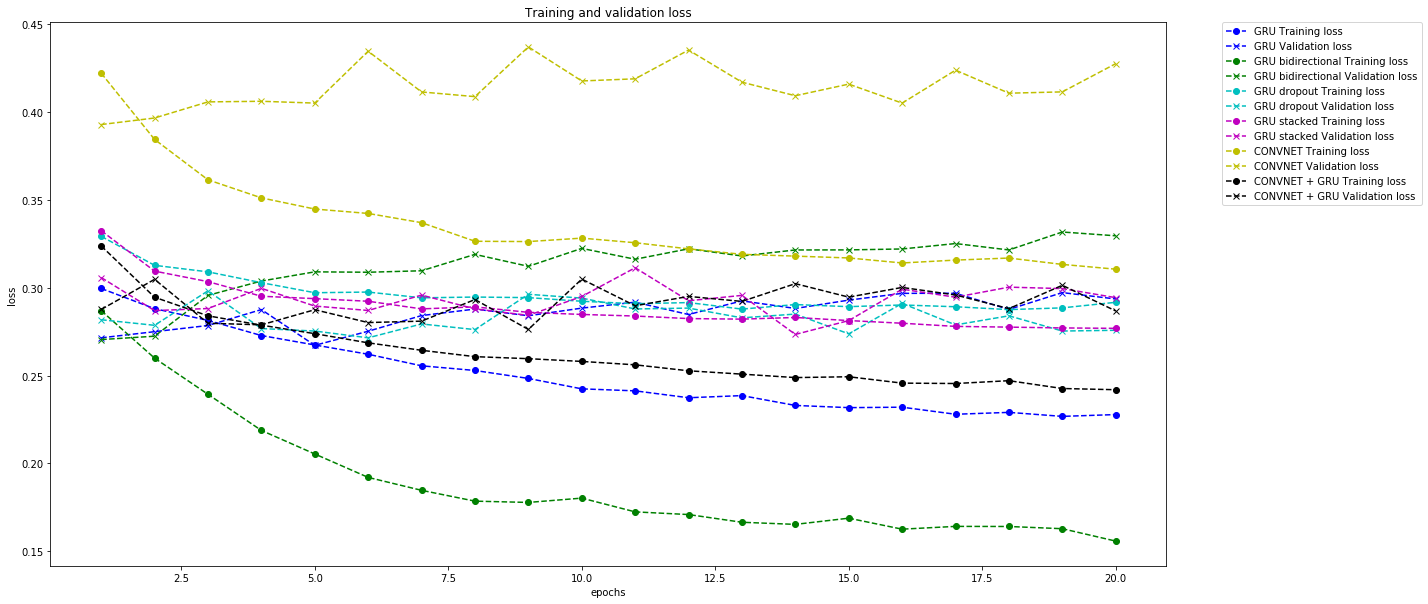

In [40]:
# --- Setting up the plots themselves ---

epochs = range(1, len(lossFCC) + 1)

plt.figure(figsize=(20,10))
#plt.plot(epochs, lossFCC, '--ro', label='FCC Training loss')
#plt.plot(epochs, val_lossFCC, '--rx', label='FCC Validation loss')

plt.plot(epochs, lossGRU, '--bo', label='GRU Training loss')
plt.plot(epochs, val_lossGRU, '--bx', label='GRU Validation loss')
  
plt.plot(epochs, lossGRUbi, '--go', label='GRU bidirectional Training loss')
plt.plot(epochs, val_lossGRUbi, '--gx', label='GRU bidirectional Validation loss')

plt.plot(epochs, lossGRUdropout, '--co', label='GRU dropout Training loss')
plt.plot(epochs, val_lossGRUdropout, '--cx', label='GRU dropout Validation loss')
 
plt.plot(epochs, lossGRUstacked, '--mo', label='GRU stacked Training loss')
plt.plot(epochs, val_lossGRUstacked, '--mx', label='GRU stacked Validation loss')

plt.plot(epochs, lossCON, '--yo', label='CONVNET Training loss')
plt.plot(epochs, val_lossCON, '--yx', label='CONVNET Validation loss')

plt.plot(epochs, lossCONGRU, '--ko', label='CONVNET + GRU Training loss')
plt.plot(epochs, val_lossCONGRU, '--kx', label='CONVNET + GRU Validation loss')


# plotting of training and validation losses
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

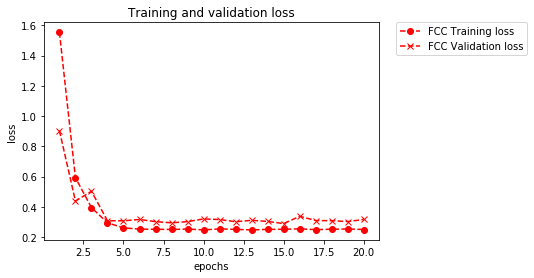

In [38]:
# --- Plot of the FCC ---

plt.figure()
plt.plot(epochs, lossFCC, '--ro', label='FCC Training loss')
plt.plot(epochs, val_lossFCC, '--rx', label='FCC Validation loss')

# plotting of training and validation losses
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()